In [29]:
from langchain_groq import ChatGroq
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_chroma.vectorstores import Chroma
from pydantic import BaseModel, Field
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
import operator
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import StateGraph,END

In [30]:
# model
llm = ChatGroq(model="llama-3.3-70b-versatile")

In [31]:
# Embeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

# dimentionality of the input vector...feature representation of the above model
len(embeddings.embed_query("helo"))

# load the data 
from langchain_community.document_loaders import DirectoryLoader, TextLoader
loader = DirectoryLoader("../data",glob="./*.txt",loader_cls=TextLoader)
text_docs =loader.load()
text_docs

# split the docs into chunks..
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter =RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50
)

chunks =text_splitter.split_documents(text_docs)

# indexing automatically will be created in chroma db...

db = Chroma.from_documents(
    chunks,
    embedding=embeddings
)

retriever = db.as_retriever(search_kwargs={"k":3})



In [32]:
# create pydantic class
class InputCategoryParser(BaseModel):
    category: str=Field(description="selected category")
    Reasoning: str=Field(description="Reasoning behind the selected category")

# outputparser
parser = PydanticOutputParser(pydantic_object=InputCategoryParser)

In [33]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],operator.add]

In [34]:
workflow =StateGraph(AgentState)


In [35]:
def Supervisor_node(state:AgentState):
    question = state["messages"][-1]
    print("Question:",question)

    template="""your task is to classify the given query into one of the following categories: [USA GDP, Not Related, Real Time]. 
    User query: {question} {format_instructions}
    """
    prompt =PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions":parser.get_format_instructions()}
    )
    

    chain = prompt| llm | parser

    response = chain.invoke({"question":question})

    print("Parsed Response is :",response)

    return{"messages": [response.category]}

In [36]:
state ={"messages":["what is a GDP of USA"]}

Supervisor_node(state)

Question: what is a GDP of USA
Parsed Response is : category='USA GDP' Reasoning="The query directly mentions 'GDP of USA', which indicates that the user is seeking information about the Gross Domestic Product of the United States."


{'messages': ['USA GDP']}

In [37]:
state ={"messages":["what is langchain?"]}

Supervisor_node(state)

Question: what is langchain?
Parsed Response is : category='Not Related' Reasoning="The query 'what is langchain?' does not contain any information related to USA GDP or real-time data, therefore it is classified as 'Not Related'."


{'messages': ['Not Related']}

In [38]:
def router(state: AgentState):
    print("---> Router --->")
    
    category = state["messages"][-1]  
    print("Parsed category:", category)

    if category == "USA GDP":
        return "RAG Call"
    elif category == "Not Related":
        return "LLM Call"
    else:
        return "WebCrawler Call"

In [39]:
def LLM_node(state:AgentState):
    # LLM function
    print("---> LLM call --->")
    question = state["messages"][0]   # passing the first message (question) to the LLM
    # Normal LLM call 
    query = "Anwer the following question with your knowlwdge of the real world. Following of the user question:" + question
    response = llm.invoke(query)
    return {"messages": [response.content]}
    

In [40]:
def format_docs(docs):
    return("\n\n".join(doc.page_content for doc in docs))

In [41]:
def RAG_node(state:AgentState):
    print("---> RAG call --->")

    question =state["messages"][0]

    prompt = PromptTemplate(
        template=""" You are an assistant for question-answering tasks. Use the following pices of retrieved context to answer the question.if you don't know the answer, just say you dont know. Use three sentences maximum and keep the answer concise. \n Question: {question} \n context: {context} \nAnswer:""",

        input_variables=["context","question"]
    )

    rag_chain =(
        {
        "context":retriever 
        | format_docs,"question":RunnablePassthrough() }
        | prompt
        | llm
        | StrOutputParser())

    result =rag_chain.invoke(question)
    return {"messages":[result]}

In [ ]:
def WebCrawler_node(state:AgentState):
    # webcrawler function
    tool = TavilySearchResults()
    
    print("---> WebCrawler call --->")
    question = state["messages"][0]   # passing the first message (question) to the LLM
     
    query = "Anwer the following question with your knowlwdge of the real world. Following of the user question:" + question
    response = tool.invoke(query)
    content= []
    for r in response:
        content.append(r.get("content"))
    
    return {"messages": [content]}
    #return {"messages": [response]}
    
    
    

In [57]:
state={"messages":["what happeend to the AirIndia flight yesterday?"]}
WebCrawler_node(state)

---> WebCrawler call --->


{'messages': [['An Air India flight en route to London carrying 242 passengers and crew crashed shortly after taking off from the western city of Ahmedabad in India’s Guajarat state earlier today.\n\n*Here’s* [*what we know*](https://www.cnn.com/2025/06/12/india/air-india-plane-crash-intl?cid=ios_app) *so far about the crash:* [...] **Timeline:** According to aviation tracker Flightradar24, Air India Flight 171, a Boeing 787-8 Dreamliner, departed from Ahmedabad International airport at 1:38 p.m. local time (4:08 a.m. ET) with a destination of London Gatwick Airport. The aircraft’s signal was lost less than a minute later, at an altitude of 625 feet. [...] **All aboard the plane except one died:** Air India confirmed in a statement that of the 242 people on board its plane, all but one died. That’s [241 confirmed fatalities](https://www.cnn.com/world/live-news/ahmedabad-india-plane-crash-06-12-25#cmbtnbciu00003b6ssybftu06) from just the plane. The flight was carrying 230 passengers and

In [44]:

def Validation_node(state: AgentState) -> AgentState:
    print("---> Validation Node <----")

    user_question = state["messages"][0]
    llm_response = state["messages"][-1]

    prompt = PromptTemplate(
        template="""You are an assistant to validate the response produced by an LLM.
            Use the following response and validate it against the user query.
            If the response is helpful and correct, return YES. Otherwise, return NO.
            Question: {user_question}
            Response: {llm_response}""",
            
        input_variables=["user_question", "llm_response"]
    )

    llm = ChatGroq(model="llama-3.3-70b-versatile")
    chain = prompt | llm | StrOutputParser()

    result = chain.invoke({
        "user_question": user_question,
        "llm_response": llm_response
    })

    print(f"[Validation Result] Raw output: {result}")

    is_valid = "yes" in result.strip().lower()

    return {**state, "valid": is_valid}


In [45]:
# Nodes
workflow.add_node("SuperVisor",Supervisor_node)
workflow.add_node("LLM",LLM_node)
workflow.add_node("RAG",RAG_node)
workflow.add_node("WebCrawler",WebCrawler_node)
workflow.add_node("Validation",Validation_node)

#workflow.add_node("Router",router_node)


In [46]:
workflow.set_entry_point("SuperVisor")

In [47]:
# Add Edges
workflow.add_conditional_edges(
    "SuperVisor",
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
        "WebCrawler Call": "WebCrawler"
    }
)

In [48]:
workflow.add_edge("LLM","Validation")
workflow.add_edge("RAG","Validation")
workflow.add_edge("WebCrawler","Validation")

In [49]:
workflow.add_edge("Validation",END)

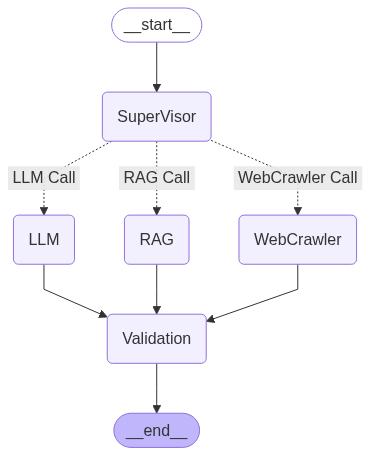

In [50]:
workflow.compile()

In [51]:
app= workflow.compile()

In [52]:

state={"messages":["what is the GDP of USA?"]}

app.invoke(state)

Question: what is the GDP of USA?
Parsed Response is : category='USA GDP' Reasoning="The user query explicitly mentions 'GDP of USA', which directly corresponds to the 'USA GDP' category."
---> Router --->
Parsed category: USA GDP
---> RAG call --->
---> Validation Node <----
[Validation Result] Raw output: YES. 

The response provides a specific estimate of the GDP of the USA, along with its global ranking and a brief explanation of its significance in the global economy, which directly addresses the user's query.


{'messages': ['what is the GDP of USA?',
  'USA GDP',
  'The GDP of the USA is estimated to be around $28 trillion USD as of 2024. This accounts for approximately 25% of the global economy, ranking the US as the largest economy in the world. The US nominal GDP is considered more reflective of actual economic size.',
  'what is the GDP of USA?',
  'USA GDP',
  'The GDP of the USA is estimated to be around $28 trillion USD as of 2024. This accounts for approximately 25% of the global economy, ranking the US as the largest economy in the world. The US nominal GDP is considered more reflective of actual economic size.']}

In [53]:
state={"messages":["what is the today's news in AirIndia flight?"]}
app.invoke(state)

Question: what is the today's news in AirIndia flight?
Parsed Response is : category='Not Related' Reasoning='The query is asking about news related to AirIndia flight, which is not related to USA GDP or Real Time data.'
---> Router --->
Parsed category: Not Related
---> LLM call --->
---> Validation Node <----
[Validation Result] Raw output: NO.

The response does not provide today's news about Air India flights as requested by the user. It provides general information about how to find the latest news and some outdated information about Air India's developments as of 2023. The response explicitly states that it does not have real-time information, which makes it unhelpful in answering the user's question about current news.


{'messages': ["what is the today's news in AirIndia flight?",
  'Not Related',
  "As of my knowledge cutoff in 2023, I don't have real-time information. However, I can provide some general information about Air India.\n\nTo get the latest news about Air India flights, I recommend checking reputable news sources such as:\n\n1. Air India's official website (airindia.in) for updates on flight schedules, cancellations, or disruptions.\n2. News websites like BBC, CNN, or Indian news outlets like The Times of India, Hindustan Times, or The Indian Express.\n3. Social media platforms like Twitter, where you can follow Air India's official handle (@airindia) or hashtags related to the airline.\n\nSome recent developments in Air India that I'm aware of include:\n\n* Air India's plans to expand its fleet and routes, including the introduction of new aircraft and the resumption of flights to certain destinations.\n* The airline's efforts to improve its services, including the introduction of new i

In [54]:
state={"messages":["what is langgraph"]}
app.invoke(state)

Question: what is langgraph
Parsed Response is : category='Not Related' Reasoning="The query 'what is langgraph' does not contain any information related to USA GDP or Real Time data, so it is classified as Not Related."
---> Router --->
Parsed category: Not Related
---> LLM call --->
---> Validation Node <----
[Validation Result] Raw output: YES. The response is helpful and correct, providing a clear and detailed explanation of what LangGraph is, its architecture, features, and potential applications. It effectively addresses the user's query and provides relevant information about the topic.


{'messages': ['what is langgraph',
  'Not Related',
  "LangGraph is an open-source, AI-powered language model developed by the LangGraph team. It's designed to process and generate human-like language, similar to other large language models like LLaMA, BERT, and transformers.\n\nLangGraph uses a graph-based architecture, which allows it to represent language as a complex network of interconnected concepts, entities, and relationships. This approach enables the model to capture nuanced linguistic structures, context, and semantics, making it suitable for a wide range of natural language processing (NLP) tasks, such as:\n\n1. Text generation\n2. Language translation\n3. Question answering\n4. Sentiment analysis\n5. Text summarization\n\nThe key features of LangGraph include:\n\n1. **Graph-based architecture**: LangGraph represents language as a graph, where nodes represent words, concepts, or entities, and edges represent relationships between them.\n2. **Multitask learning**: The model 

In [55]:
state = {"messages": ["where is Liberty of statue?"]}
app.invoke(state)

Question: where is Liberty of statue?
Parsed Response is : category='Not Related' Reasoning="The query is asking about the location of the Statue of Liberty, which is a geographical question and does not relate to the USA's GDP or Real Time information."
---> Router --->
Parsed category: Not Related
---> LLM call --->
---> Validation Node <----
[Validation Result] Raw output: YES.


{'messages': ['where is Liberty of statue?',
  'Not Related',
  'The Statue of Liberty is located in New York City, United States. Specifically, it is situated on Liberty Island in New York Harbor, within the state of New York. The statue was a gift from the people of France to the people of the United States and was dedicated on October 28, 1886. It has since become one of the most iconic symbols of American freedom and democracy.',
  'where is Liberty of statue?',
  'Not Related',
  'The Statue of Liberty is located in New York City, United States. Specifically, it is situated on Liberty Island in New York Harbor, within the state of New York. The statue was a gift from the people of France to the people of the United States and was dedicated on October 28, 1886. It has since become one of the most iconic symbols of American freedom and democracy.']}

In [56]:
state = {"messages": ["where is Tajmahal?"]}
app.invoke(state)

Question: where is Tajmahal?
Parsed Response is : category='Not Related' Reasoning='The query is about the location of the Taj Mahal, which is not related to USA GDP or real-time information.'
---> Router --->
Parsed category: Not Related
---> LLM call --->
---> Validation Node <----
[Validation Result] Raw output: YES.


{'messages': ['where is Tajmahal?',
  'Not Related',
  'The Taj Mahal is located in Agra, Uttar Pradesh, India. It is situated on the southern bank of the Yamuna River, about 230 kilometers (143 miles) south of New Delhi, the capital city of India. The Taj Mahal is one of the most famous and iconic monuments in the world, and it is considered a symbol of love and beauty. It was built by Mughal Emperor Shah Jahan in memory of his wife, Mumtaz Mahal, and it is now a UNESCO World Heritage Site.',
  'where is Tajmahal?',
  'Not Related',
  'The Taj Mahal is located in Agra, Uttar Pradesh, India. It is situated on the southern bank of the Yamuna River, about 230 kilometers (143 miles) south of New Delhi, the capital city of India. The Taj Mahal is one of the most famous and iconic monuments in the world, and it is considered a symbol of love and beauty. It was built by Mughal Emperor Shah Jahan in memory of his wife, Mumtaz Mahal, and it is now a UNESCO World Heritage Site.']}